<a href="https://colab.research.google.com/github/aslanides/aslanides.github.io/blob/master/colabs/2019-10-06-bias-variance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bias-variance decomposition


A central result in 'classical' machine learning and statistics is known as the _bias-variance decomposition_. Let's flesh it out.

Consider the univariate regression problem in which we have $x\in\mathbb{R}^D$, $y\in\mathbb{R}$, and want to learn the conditional distribution $p(y\lvert x)$, or at least its mean $\mathbb{E}[y\lvert x]$, via some parametric function $f(x)$. Now, any finite training set of $N$ points drawn from $p$ will itself be a random variable:

$$
\mathcal{D}=\left\{\left(x^{(n)}, y^{(n)}\right) \big|\ (x, y) \sim p(x, y)\right\}_{n=1}^N.
$$

The bias-variance decomposition considers how the risk (expected loss under $p$ for a model $f$) depends on this random variable. Let's do the calculation first, then tease out the intuition.


The risk under the joint distribution $p(x,y)$ for a regression task using the square loss is given by

$$
\begin{aligned}
\mathbb{E}[\mathcal{L}] 
  &\stackrel{\mathrm{(a)}}{=} \mathbb{E}_{xy}\mathbb{E}_{\mathcal{D}}\Big[\{y - f(x; \mathcal{D})\}^2\Big] \\
  &\stackrel{\mathrm{(b)}}{=} \mathbb{E}_{xy}\mathbb{E}_{\mathcal{D}}\Big[\{y - h(x) + h(x) - f(x; \mathcal{D})\}^2\Big] \\
  &\stackrel{\mathrm{(c)}}{=} \mathbb{E}_{xy}\Big[\{y - h(x)\}^2\Big]
     + \mathbb{E}_x\mathbb{E}_\mathcal{D}\Big[\{h(x) - f(x; \mathcal{D})\}^2\Big] \\
  &\stackrel{\mathrm{(d)}}{=} \mathbb{E}_{xy}\Big[\{y - h(x)\}^2\Big]
     + \mathbb{E}_x\mathbb{E}_\mathcal{D}\Big[
        \big\{h(x) 
        - \mathbb{E}_\mathcal{D}[f(x;\mathcal{D})] 
        + \mathbb{E}_\mathcal{D}[f(x;\mathcal{D})] 
        -  f(x; \mathcal{D})\big\}^2
      \Big] \\
  &\stackrel{\mathrm{(e)}}{=} \mathbb{E}_{xy}\Big[\{y - h(x)\}^2\Big]
     + \mathbb{E}_x\Big[\big\{h(x) - \mathbb{E}_\mathcal{D}[f(x;\mathcal{D})]\big\}^2\Big]
     + \mathbb{E}_x\mathbb{E}_\mathcal{D}\Big[\big\{f(x; \mathcal{D}) - \mathbb{E}_\mathcal{D}[f(x;\mathcal{D})]\big\}^2\Big] \\
  &\stackrel{\mathrm{(f)}}{=} \underbrace{\int\int\{y - h(x)\}^2p(x,y)\mathrm{d}x\mathrm{d}y}_{\mathrm{noise}}
     + \underbrace{\int\{h(x) - \mathbb{E}_\mathcal{D}[f(x;\mathcal{D})]\big\}^2p(x)\mathrm{d}x}_{\mathrm{bias}^2}
     + \underbrace{\int\mathbb{E}_\mathcal{D}\Big[\big\{f(x; \mathcal{D}) - \mathbb{E}_\mathcal{D}[f(x;\mathcal{D})]\big\}^2\Big]p(x)\mathrm{d}x}_{\mathrm{variance}},
\end{aligned}
$$

reasoning:
* $\mathrm{(a)}$ expresses the fact that $f$ is a function of both its inputs $x$ and the dataset $\mathcal{D}$ it is trained on, which is a random variable.
* $\mathrm{(b)}$ uses the additive identity; here $h(x):=\mathbb{E}_y[y\lvert x]$ is the optimal hypothesis under the square loss,
* $\mathrm{(c)}$ follows by noting that the cross-term vanishes since $\mathbb{E}_{xy}[y-h(x)] = 0$,
* $\mathrm{(d)}$ and $\mathrm{(e)}$ follow by again using the additive identity and noting that the cross-term is zero, and
* $\mathrm{(f)}$ spells out the expectations in terms of the underlying marginals.

This decomposition tells us a few things:

- In all but the deterministic case, all expectation models will unsurprisingly incur non-zero risk from irreducible noise in the data.
- Models that don't have sufficient capacity/flexibility or that are poorly specified will incur non-zero risk in expectation due to bias ('underfitting') resulting from being unable to closely match $h(x)$.
- Models that 'overfit' to their datasets $\mathcal{D}$ will have high variance over all $\mathcal{D}$; this also contributes to the true risk.

## Simple demonstration

Let's make something like Figure 3.5 of Bishop. We draw our data from $p(x,y)$ defined by:

$$
p(x) = \mathcal{U}\left(-\frac{\pi}{2}, \frac{\pi}{2}\right) \\
p(y\lvert x) = \mathcal{N}\left(\sin(x), \sigma^2\right)
$$



In [0]:
# @title Imports

import numpy as np
import pandas as pd
import plotnine as gg
import sklearn

gg.theme_set(gg.theme_bw());

In [0]:
# @title Create the dataset

num_data = 100
noise_sigma = 0.2

train_xs = np.random.uniform(-np.pi, np.pi, size=num_data)
train_ys = np.sin(train_xs) + noise_sigma * np.random.randn(num_data)

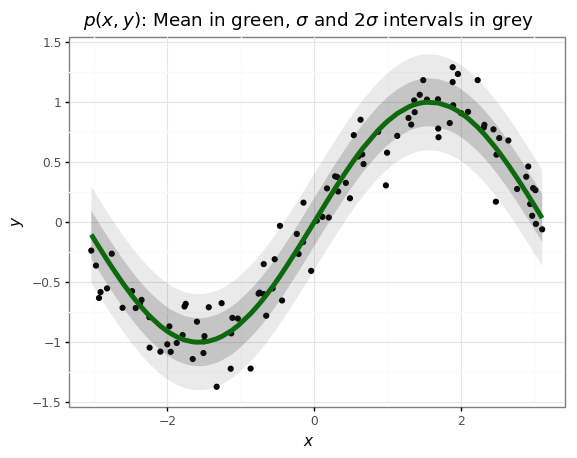

<ggplot: (8740264119784)>

In [230]:
# @title Plot the data and its underlying distribution.

df = pd.DataFrame({'x': train_xs,
                   'y': train_ys, 
                   'h': np.sin(train_xs),
                   'std': noise_sigma,
                   })

p = (gg.ggplot(df)
     + gg.aes(x='x', y='h')
     + gg.geom_point(gg.aes(y='y'))
     + gg.geom_line(color='green', size=2)
     + gg.geom_ribbon(gg.aes(ymin='h - std', ymax='h + std'), alpha=0.2)
     + gg.geom_ribbon(gg.aes(ymin='h - 2 * std', ymax='h + 2 * std'), alpha=0.1)
     + gg.ggtitle(r'$p(x, y)$: Mean in green, $\sigma$ '
                  'and 2$\sigma$ intervals in grey')
     + gg.xlab(r'$x$')
     + gg.ylab(r'$y$')
)
p

Let's let fit a linear model

$$f(x;\theta)=\theta^T\phi(x)$$

where $\theta\in\mathbb{R}^M$ are model weights and $\phi: \mathbb{R}\to\mathbb{R}^M$ are features. Some example features:

- Polynomial:
  $$\phi_P^m(x) = x^m$$
- Fourier:
  $$\phi_F^m(x) = \sin\left(\frac{2\pi m x}{M}\right)$$
- Gaussian: $$\phi_G^m(x) = \exp\left(-\left[x + \frac{M\pi - 2\pi m}{M}\right]^2\right)$$

We'll minimize the $l_2$-regularized empirical risk

$$
\hat{\mathcal{L}}= + \lambda\big\|\theta\big\|^2_2 + \sum_{n=1}^N \left(y^{(i)} - f\left(x^{(i)};\theta\right)\right)^2.
$$

In [0]:
# Number of training points, number of datasets to sample, number of features to use.
num_train = 25
num_models = 20
num_features = 24

# Define the features.
polynomial_features = np.array([train_xs**n for n in range(num_features)]).T
fourier_features = np.array([np.sin(2*np.pi*n*train_xs / num_features) for n in range(num_features)]).T
gaussian_features = np.array([np.exp(-(train_xs - (2*np.pi*x/num_features - np.pi))**2) for x in range(num_features)]).T

# Train for different amounts of regularization.
features = gaussian_features
results_df = pd.DataFrame()
for lam in [1e-3, 1e-1, 1e0, 1e1]:
  for idx in range(num_models):
    # Sample a small subset of the dataset.
    train_idx = np.random.randint(len(features), size=num_train)
    train_features = features[train_idx]
    train_targets = train_ys[train_idx]

    # Fit a model to it.
    model = sklearn.linear_model.Ridge(alpha=lam)
    model.fit(train_features, train_targets)

    # Collect results.
    df = pd.DataFrame({
        'x': train_xs,
        'y': train_ys,
        'h': np.sin(train_xs),
        'f': model.predict(features),
        'idx': [idx] * num_data,
        'lam': lam,
    })
    results_df = pd.concat([results_df, df])

In [0]:
# Plot our fitted functions.
fit_plot = (gg.ggplot(results_df)
            + gg.aes(x='x')
            
            + gg.geom_line(gg.aes(y='f', group='idx'), color='red', alpha=0.5)
            + gg.facet_wrap('lam', labeller='label_both', ncol=4)
            + gg.coord_cartesian(ylim=[-1.1, 1.1])
            + gg.theme(figure_size=(12, 3))
            + gg.xlab(r'$x$')
            + gg.ylab(r'$f(x)$')
)

In [0]:
# Plot their mean, over the datasets D.
mean_df = results_df.groupby(['x', 'lam', 'y', 'h']).agg({'f': np.mean}).reset_index()

mean_plot = (gg.ggplot(mean_df)
             + gg.aes(x='x', y='f')
             + gg.geom_line(gg.aes(y='h'), color='green')
             + gg.geom_line(color='red')
             + gg.facet_wrap('lam', labeller='label_both', ncol=4)
             + gg.theme(figure_size=(12, 3))
             + gg.xlab(r'$x$')
             + gg.ylab(r'$\mathbb{E}_\mathcal{D}f(x)$')
)

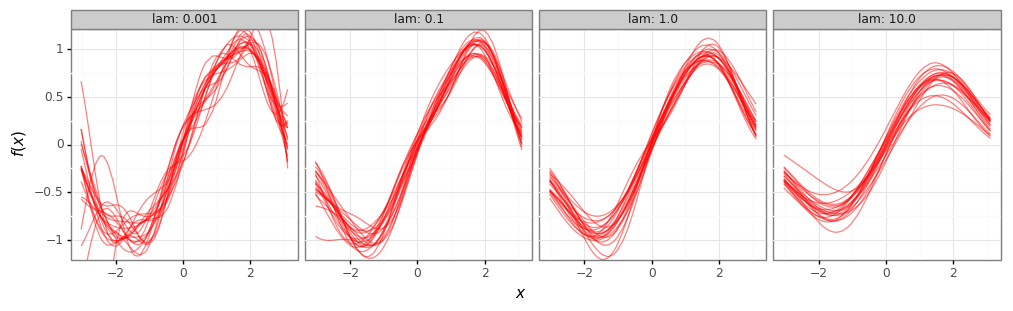

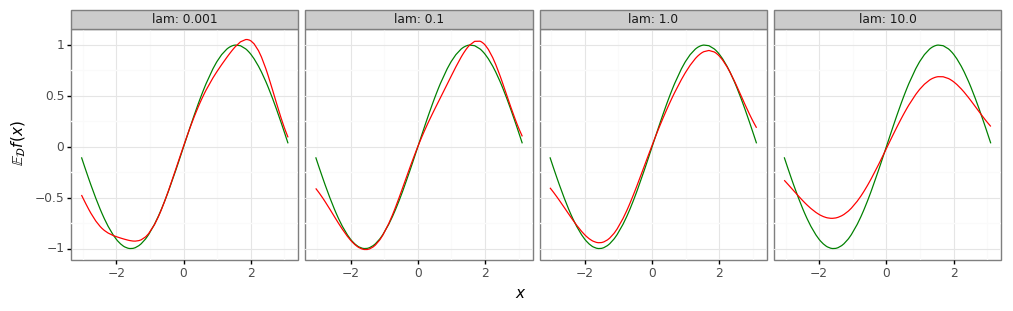

[<ggplot: (8740266243115)>, <ggplot: (-9223363296588723866)>]

In [224]:
# Weak regularizer (low lambda) -> low bias, high variance.
print(fit_plot)

# Strong regularizer (high lambda) -> high bias, low variance.
print(mean_plot)